<a href="https://colab.research.google.com/github/Shailajgautam/FDV-AI-Intern-Task/blob/main/Intern_Week_3_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset**

In [3]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [4]:
import zipfile
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


# **Data Preprocessing**

In [5]:
import numpy as np
import os
from PIL import Image
from skimage import io, color, exposure, filters
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt  # Add this line for plotting


In [6]:
# Set the path to the dataset directory
dataset_dir = "/content/dataset/dataset"


In [7]:
def load_and_preprocess_images(dataset_dir, image_size=(56, 56)):
    images = []
    labels = []

    # Iterate through each class directory
    for class_label in range(1, 59):  # Classes from 1 to 58
        class_dir = os.path.join(dataset_dir, str(class_label))

        # Iterate through each image in the class directory
        for root, _, files in os.walk(class_dir):
            for image_file in files:
                image_path = os.path.join(root, image_file)

                # Load image, convert to grayscale, resize, and normalize
                image = Image.open(image_path).convert('L').resize(image_size)
                image_array = np.array(image) / 255.0

                images.append(image_array)
                labels.append(class_label)

    # Get unique classes found
    unique_classes = list(set(labels))
    print("Unique classes found:", unique_classes)

    return np.array(images), np.array(labels)


In [8]:
# Load and preprocess images
images, labels = load_and_preprocess_images(dataset_dir)
print("Total images loaded:", len(images))


Unique classes found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
Total images loaded: 12912


In [9]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [10]:
# Reshape X_train to include a single channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [11]:
# Convert labels to integers and subtract 1
y_train = np.array([int(label) - 1 for label in y_train])
y_test = np.array([int(label) - 1 for label in y_test])
y_val = np.array([int(label) - 1 for label in y_val])


# **Data Augmentation**

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)


In [13]:
# Fit the data generator on the training data
datagen.fit(X_train)


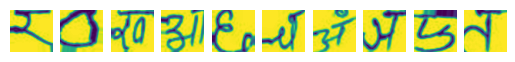

In [14]:
# Example of generating augmented images
num_augmented_images = 10
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=num_augmented_images):
    # Show the first num_augmented_images images
    for i in range(num_augmented_images):
        plt.subplot(1, num_augmented_images, i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    plt.show()
    break  # Only generate one batch of augmented images for demonstration

# **Building Model**

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from keras.utils import plot_model

In [16]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(56, 56, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(58, activation='softmax')
])


In [17]:
# Get a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 56, 56, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                        

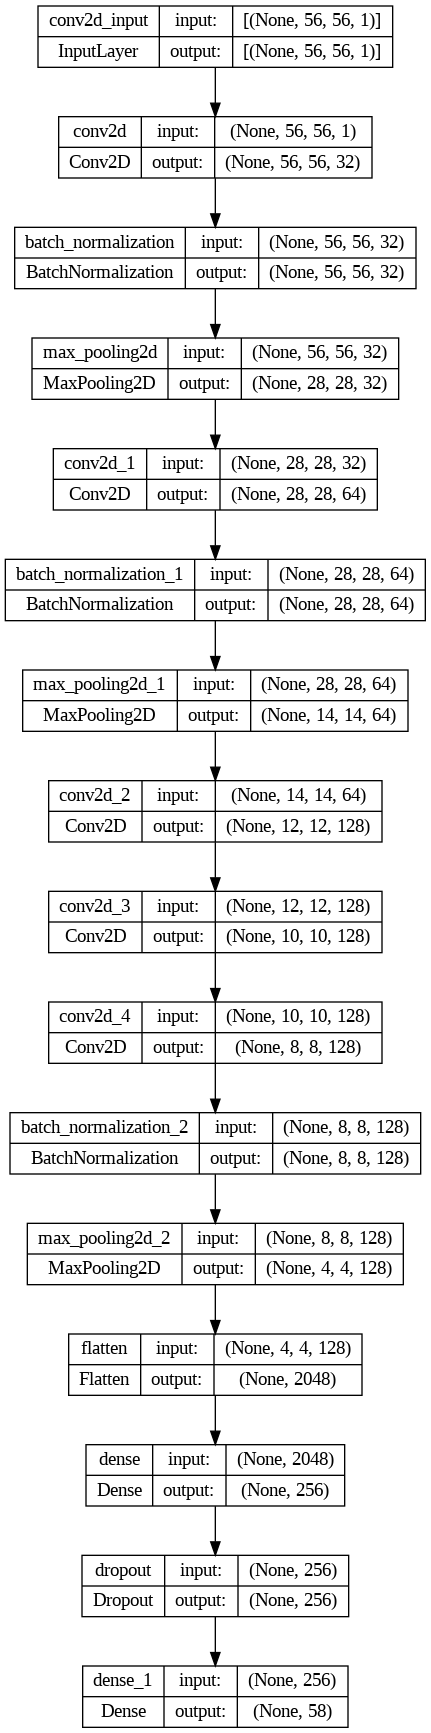

In [18]:
# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [19]:
# Learning Rate Scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)

In [20]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/100
258/258 [==============================] - 15s 28ms/step - loss: 3.2579 - accuracy: 0.2105 - val_loss: 21.6553 - val_accuracy: 0.0165 - lr: 0.0010
Epoch 2/100
258/258 [==============================] - 5s 19ms/step - loss: 1.9239 - accuracy: 0.4692 - val_loss: 2.3850 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 3/100
258/258 [==============================] - 5s 20ms/step - loss: 1.3958 - accuracy: 0.6006 - val_loss: 0.6584 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 4/100
258/258 [==============================] - 5s 20ms/step - loss: 1.0943 - accuracy: 0.6765 - val_loss: 1.0614 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 5/100
258/258 [==============================] - 7s 25ms/step - loss: 0.9106 - accuracy: 0.7290 - val_loss: 0.6966 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 6/100
258/258 [==============================] - 5s 20ms/step - loss: 0.7548 - accuracy: 0.7685 - val_loss: 0.3564 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 7/100
258/258 [==============================] - 5

In [23]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


81/81 [==============================] - 1s 9ms/step - loss: 0.1375 - accuracy: 0.9756
Test Loss: 0.13754715025424957
Test Accuracy: 0.9756097793579102


In [24]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate additional evaluation metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

81/81 [==============================] - 0s 3ms/step
Precision: 0.9764101087204319
Recall: 0.975609756097561
F1-score: 0.9756645773626755


In [25]:
# Generate the classification report
report = classification_report(y_test, y_pred_classes)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.95      1.00      0.98        41
           2       0.96      0.98      0.97        46
           3       1.00      0.90      0.95        39
           4       1.00      1.00      1.00        35
           5       1.00      0.95      0.98        43
           6       1.00      0.95      0.98        44
           7       1.00      0.90      0.95        41
           8       0.97      0.92      0.95        39
           9       0.97      1.00      0.99        36
          10       0.98      0.98      0.98        42
          11       1.00      0.94      0.97        51
          12       0.98      1.00      0.99        44
          13       0.89      0.94      0.91        34
          14       0.98      0.93      0.96        60
          15       1.00      1.00      1.00        33
          16       0.88      0.94      0.91        49
    

Original simple model was 69%

In [26]:
# Save the model
model.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


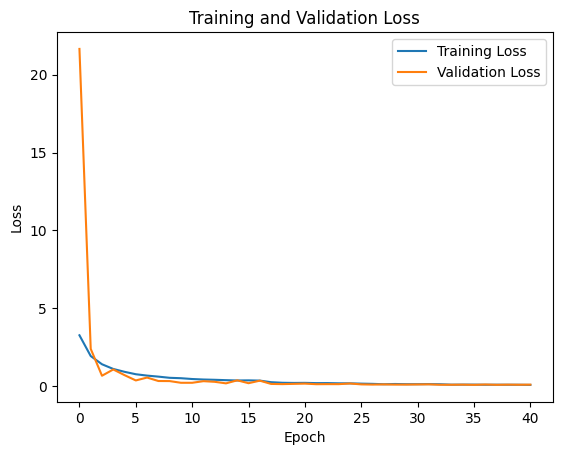

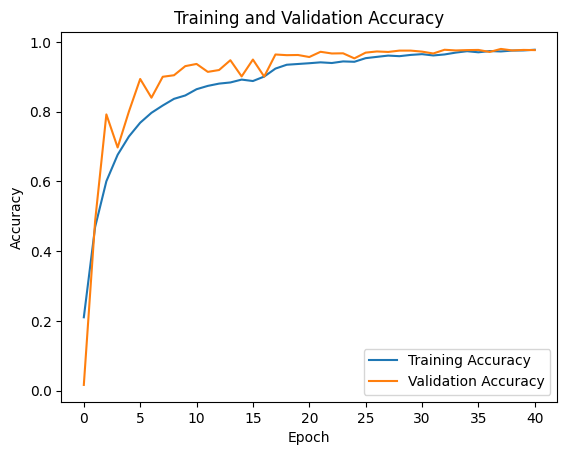

In [27]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


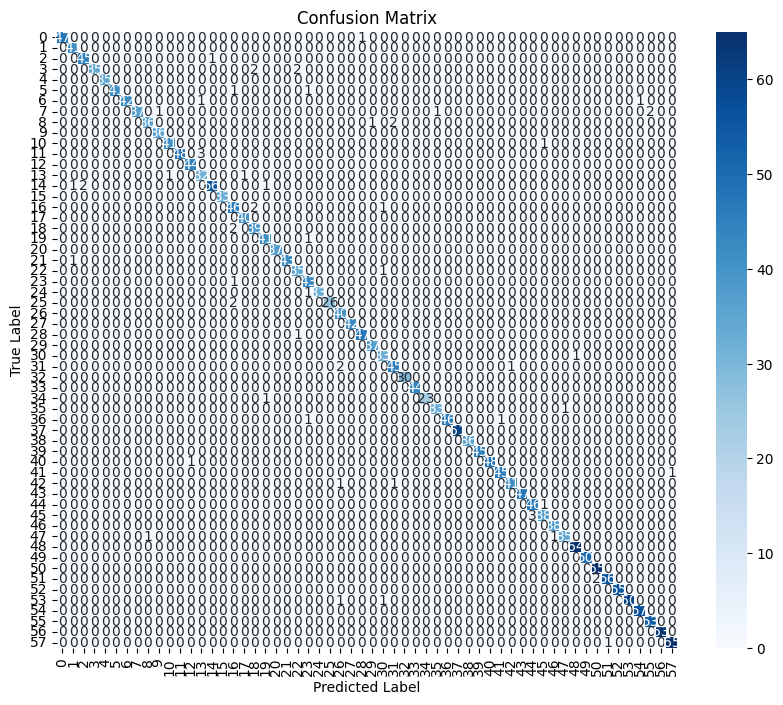

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels
class_labels = [str(i) for i in range(conf_matrix.shape[0])]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# **Building Fastapi**

In [29]:
!pip install fastapi
!pip install uvicorn
!pip install python-multipart
!pip install pillow
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import numpy as np
from io import BytesIO
from skimage import exposure, filters
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from pyngrok import ngrok


In [31]:
# Set your Ngrok authentication token
ngrok.set_auth_token("2fOV1QHgNwrkgPYU5rIh1eCJvIs_3zpxDk6Z4UPBXGo2bB86i")


In [32]:
# Initialize FastAPI app
app = FastAPI()


In [33]:
# Load pre-trained model
model = load_model('/content/model.h5')


In [34]:
# Define the mapping from class to phonetics character
class_to_phonetics = {
    # Numerals
    48: "Śūn'ya", 49: "ēka", 50: "du'ī", 51: "tīna", 52: "cāra",
    53: "pām̐ca", 54: "cha", 55: "sāta", 56: "āṭha", 57: "nau",
    # Vowels
    36: "a", 37: "ā", 38: "i", 39: "ī", 40: "u",
    41: "ū", 42: "ē", 43: "ai", 44: "ō", 45: "au",
    46: "aṁ", 47: "aḥ",
    # Consonants
    0: "ka", 1: "kha", 2: "ga", 3: "gha", 4: "ṅa",
    5: "ca", 6: "cha", 7: "ja", 8: "jha", 9: "ña",
    10: "ṭa", 11: "ṭha", 12: "ḍa", 13: "ḍha", 14: "ṇa",
    15: "ta", 16: "tha", 17: "da", 18: "dha", 19: "na",
    20: "pa", 21: "pha", 22: "ba", 23: "bha", 24: "ma",
    25: "ya", 26: "ra", 27: "la", 28: "va", 29: "śa",
    30: "ṣa", 31: "sa", 32: "ha", 33: "kṣa", 34: "tra",
    35: "jña"
}


In [35]:
# Define the mapping from class to Devanagari character
class_to_devanagari = {
        # Numerals
    48: "०", 49: "१", 50: "२", 51: "३", 52: "४",
    53: "५", 54: "६", 55: "७", 56: "८", 57: "९",
    # Vowels
    36: "अ", 37: "आ", 38: "इ", 39: "ई", 40: "उ",
    41: "ऊ", 42: "ए", 43: "ऐ", 44: "ओ", 45: "औ",
    46: "अं", 47: "अः",
    # Consonants
    0: "क", 1: "ख", 2: "ग", 3: "घ", 4: "ङ",
    5: "च", 6: "छ", 7: "ज", 8: "झ", 9: "ञ",
    10: "ट", 11: "ठ", 12: "ड", 13: "ढ", 14: "ण",
    15: "त", 16: "थ", 17: "द", 18: "ध", 19: "न",
    20: "प", 21: "फ", 22: "ब", 23: "भ", 24: "म",
    25: "य", 26: "र", 27: "ल", 28: "व", 29: "श",
    30: "ष", 31: "स", 32: "ह", 33: "क्ष", 34: "त्र",
    35: "ज्ञ"
}


In [36]:
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # Print request body for debugging
    contents = await file.read()
    print("Request Body:", contents)

    # Read image file
    img = Image.open(BytesIO(contents))

    # Resize image to match model input shape
    img = img.resize((64, 64))

    # Convert image to grayscale
    img = img.convert('L')

    # Convert image to numpy array
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Normalize image data
    img_array = img_array / 255.0


    # Save preprocessed image
    save_path = "preprocessed_image.jpg"
    img.save(save_path)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = int(np.argmax(prediction))  # Convert numpy int to Python int

    # Convert predicted class number to phonetics
    predicted_devanagari = class_to_devanagari.get(predicted_class, "Unknown")

    prediction_probabilities = prediction.tolist()  # Convert numpy array to Python list

    return {"predicted_devanagari": predicted_devanagari, "prediction_probabilities": prediction_probabilities}



In [ ]:
# Run FastAPI app using Uvicorn with Ngrok
import nest_asyncio
import uvicorn

# Run FastAPI app
def run_app():
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Start Ngrok tunnel
def start_ngrok():
    ngrok_tunnel = ngrok.connect(8000)
    print("Public URL:", ngrok_tunnel.public_url)
    return ngrok_tunnel

if __name__ == "__main__":
    tunnel = start_ngrok()
    run_app()